Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Training Generator1024...
Epoch [10/1000] Loss: 0.3943
Epoch [20/1000] Loss: 0.3236
Epoch [30/1000] Loss: 0.2876
Epoch [40/1000] Loss: 0.2657
Epoch [50/1000] Loss: 0.2470
Epoch [60/1000] Loss: 0.2403
Epoch [70/1000] Loss: 0.2306
Epoch [80/1000] Loss: 0.2192
Epoch [90/1000] Loss: 0.2112
Epoch [100/1000] Loss: 0.2043
Epoch [110/1000] Loss: 0.2022
Epoch [120/1000] Loss: 0.1932
Epoch [130/1000] Loss: 0.2006
Epoch [140/1000] Loss: 0.1998
Epoch [150/1000] Loss: 0.1872
Epoch [160/1000] Loss: 0.1819
Epoch [170/1000] Loss: 0.1775
Epoch [180/1000] Loss: 0.1745
Epoch [190/1000] Loss: 0.1702
Epoch [200/1000] Loss: 0.1674
Epoch [210/1000] Loss: 0.1644
Epoch [220/1000] Loss: 0.1607
Epoch [230/1000] Loss: 0.1576
Epoch [240/1000] Loss: 0.1557
Epoch [250/1000] Loss: 0.1535
Epoch [260/1000] Loss: 0.1501
Epoch [270/1000] Loss: 0.1480
Epoch [280/1000] Loss: 0.1445
Epoch [290/1000] Loss: 0.1448
Epoch [300/1000] Loss: 0.1407
Epoch [310/1000] Loss: 0

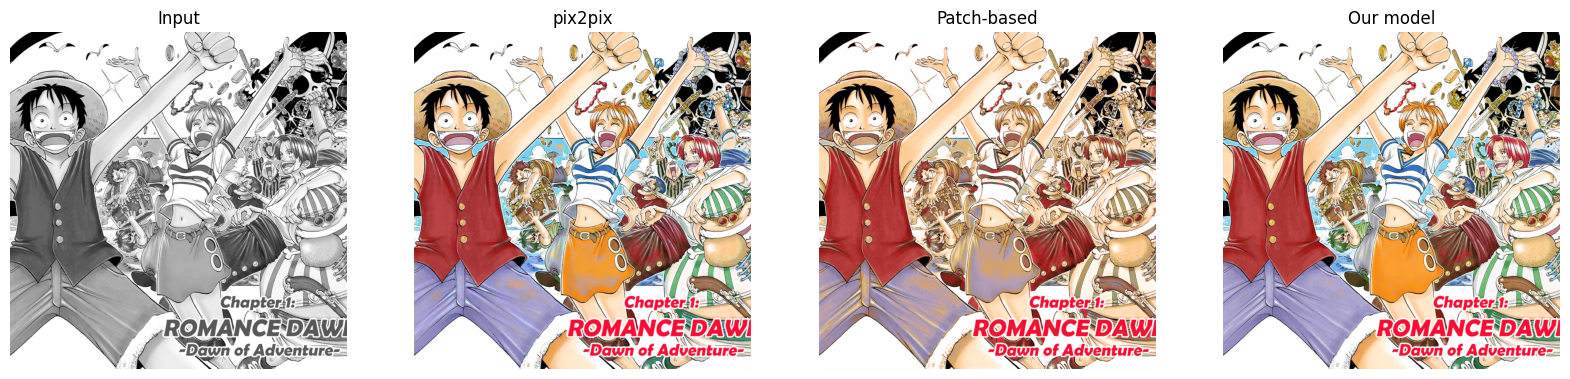

1024x1024 models saved.


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_msssim import ssim  # pip install pytorch-msssim

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

def preprocess_image(image_path, size=(1024,1024)):
    try:
        img = Image.open(image_path).convert("RGB")
        img = img.resize(size, Image.BILINEAR)
        img = np.array(img).astype(np.float32)
        # Normalize image to [-1, 1]
        img = img / 127.5 - 1.0
        # Rearrange from (H,W,C) to (C,H,W) and add batch dimension
        img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)
        return img.to(device)
    except Exception as e:
        print("Error preprocessing", image_path, ":", e)
        return None

class Generator1024(nn.Module):
    def __init__(self):
        super(Generator1024, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)    # 1024 -> 512
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)   # 512 -> 256
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)  # 256 -> 128
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # 128 -> 256
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)   # 256 -> 512
        self.deconv3 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)     # 512 -> 1024

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = self.leaky_relu(self.conv3(x))
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.tanh(self.deconv3(x))
        return x

class PatchBasedModel1024(nn.Module):
    def __init__(self):
        super(PatchBasedModel1024, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)    # 1024 -> 512
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)   # 512 -> 256
        self.deconv1 = nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1)  # 256 -> 512
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)   # 512 -> 1024
        self.final_conv = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)           # Keeps resolution

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.tanh(self.final_conv(x))
        return x

class CustomFusedModel1024(nn.Module):
    def __init__(self):
        super(CustomFusedModel1024, self).__init__()
        # Branch a
        self.a_conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)   # 1024 -> 512
        self.a_conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # 512 -> 256
        self.a_conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1) # 256 -> 128
        self.a_deconv = nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1)  # 128 -> 256
        # Branch b
        self.b_conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)    # 1024 -> 1024
        self.b_conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)   # 1024 -> 512
        self.b_conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # 512 -> 256
        # Combined upsampling
        self.deconv1 = nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1)  # 256 -> 512
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)   # 512 -> 1024
        self.final_conv = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
    
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        # Branch a
        a = self.leaky_relu(self.a_conv1(x))
        a = self.leaky_relu(self.a_conv2(a))
        a = self.leaky_relu(self.a_conv3(a))
        a_up = self.relu(self.a_deconv(a))  # Output size: 256x256
        # Branch b
        b = self.relu(self.b_conv1(x))
        b = self.relu(self.b_conv2(b))
        b = self.relu(self.b_conv3(b))       # Output size: 256x256
        combined = torch.cat([a_up, b], dim=1)  # Channels: 256+256 = 512
        x = self.relu(self.deconv1(combined))   # Upsample 256->512
        x = self.relu(self.deconv2(x))          # Upsample 512->1024
        x = self.tanh(self.final_conv(x))
        return x

def train_model(model, optimizer, loss_fn, input_tensor, target_tensor, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(input_tensor)
        loss = loss_fn(output, target_tensor)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss.item():.4f}")
    return model

def compute_ssim_percent(output, target):
    # Our images are in [-1,1]: use data_range=2.
    ssim_val = ssim(output, target, data_range=2, size_average=True)
    return ssim_val.item() * 100

def show_images(input_tensor, outputs, titles):
    def tensor_to_img(t):
        img = t.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
        img = (img + 1) / 2.0
        return np.clip(img, 0, 1)
    imgs = [tensor_to_img(input_tensor)]
    imgs.extend([tensor_to_img(out) for out in outputs])
    plt.figure(figsize=(20,5))
    for i, img in enumerate(imgs):
        plt.subplot(1, len(imgs), i+1)
        plt.title(titles[i])
        plt.imshow(img)
        plt.axis("off")
    plt.show()

if __name__ == "__main__":
    # Set paths for the input (BW) and target (color) images:
    input_bw_path = "smalldatasetmanga/bw_image_1.png"
    input_color_path = "smalldatasetmanga/color_image_1.png"

    input_tensor = preprocess_image(input_bw_path)
    target_tensor = preprocess_image(input_color_path)

    if input_tensor is None or target_tensor is None:
        print("Error loading images.")
        exit()

    # Create models and send them to the GPU
    gen_model = Generator1024().to(device)
    patch_model = PatchBasedModel1024().to(device)
    custom_model = CustomFusedModel1024().to(device)

    # Define loss and optimizers (L1 loss and Adam with lr=5e-4)
    loss_fn = nn.L1Loss()
    optimizer_gen = optim.Adam(gen_model.parameters(), lr=5e-4)
    optimizer_patch = optim.Adam(patch_model.parameters(), lr=5e-4)
    optimizer_custom = optim.Adam(custom_model.parameters(), lr=5e-4)

    print("Training Generator1024...")
    gen_model = train_model(gen_model, optimizer_gen, loss_fn, input_tensor, target_tensor, epochs=1000)
    print("Training PatchBasedModel1024...")
    patch_model = train_model(patch_model, optimizer_patch, loss_fn, input_tensor, target_tensor, epochs=1000)
    print("Training CustomFusedModel1024...")
    custom_model = train_model(custom_model, optimizer_custom, loss_fn, input_tensor, target_tensor, epochs=1000)

    # Switch models to evaluation mode
    gen_model.eval()
    patch_model.eval()
    custom_model.eval()

    with torch.no_grad():
        out_gen = gen_model(input_tensor)
        out_patch = patch_model(input_tensor)
        out_custom = custom_model(input_tensor)

    ssim_gen = compute_ssim_percent(out_gen, target_tensor)
    ssim_patch = compute_ssim_percent(out_patch, target_tensor)
    ssim_custom = compute_ssim_percent(out_custom, target_tensor)

    print(f"[1024] Generator SSIM accuracy: {ssim_gen:.2f}%")
    print(f"[1024] Patch-based model SSIM accuracy: {ssim_patch:.2f}%")
    print(f"[1024] Custom fused model SSIM accuracy: {ssim_custom:.2f}%")

    show_images(input_tensor, [out_gen, out_patch, out_custom],
                ["Input", "pix2pix", "Patch-based", "Our model"])

    os.makedirs("saved_models", exist_ok=True)
    torch.save(gen_model.state_dict(), "saved_models/pix2pix_generator_1024.pt")
    torch.save(patch_model.state_dict(), "saved_models/patch_based_model_1024.pt")
    torch.save(custom_model.state_dict(), "saved_models/custom_fused_model_1024.pt")
    print("1024x1024 models saved.")
#99 1

#64 batch size, 100 epochs


In [ ]:
pip install pytorch-msssim

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))